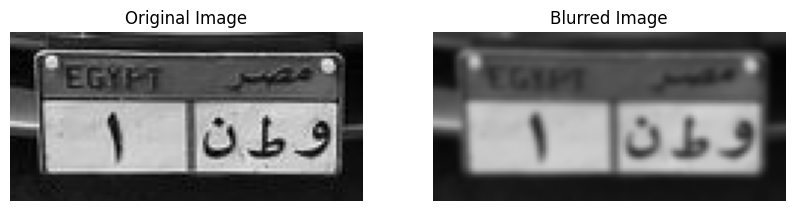

In [48]:
import cv2
import matplotlib.pyplot as plt

# Read the image
image_path = r"D:\car_plate_detection\EALPR_master\Plates_dataset\0003_license_plate_1.png"
img = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Display the original and blurred images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Blurred Image")
plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')

plt.show()


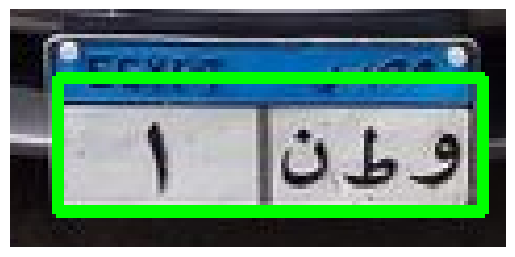

1


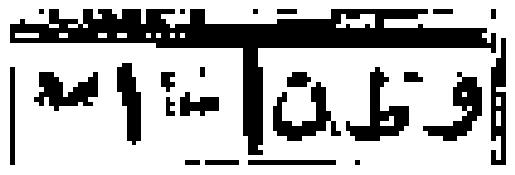

In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to binarize the image
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    return threshold

def segment_characters(image_path):
    # Preprocess the image
    preprocessed_img = preprocess_image(image_path)

    # Find contours in the image
    contours, _ = cv2.findContours(preprocessed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image to draw contours
    img_with_contours = cv2.imread(image_path)

    # List to store individual character images
    character_images = []

    for contour in contours:
        # Get the perimeter of the contour
        perimeter = cv2.arcLength(contour, True)

        # Approximate the contour with a polygon
        epsilon = 0.06 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Filter out contours with small area
        if cv2.contourArea(approx) > 50:
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(approx)

            # Extract the character region from the original image
            character = preprocessed_img[y:y+h, x:x+w]

            # Append the character image to the list
            character_images.append(character)

            # Draw a rectangle around the character on the original image
            cv2.rectangle(img_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the image with contours
    plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(len(character_images))

    # Display individual character images
    for i, char_image in enumerate(character_images):
        plt.subplot(1, len(character_images), i + 1)
        plt.imshow(char_image, cmap='gray')
        plt.axis('off')

    plt.show()

# Example usage
image_path = r"D:\car_plate_detection\EALPR_master\Plates_dataset\0003_license_plate_1.png"
seg = segment_characters(image_path)


In [92]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


In [98]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

TypeError: 'NoneType' object is not subscriptable

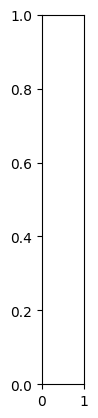

In [102]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(seg[i], cmap='gray')
    plt.axis('off')

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OCRModel(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 62) # 62 classes for chars
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

characters = "abcdefghijklmnopqrstuvwxyz0123456789" 

model = OCRModel()

# Load pretrained weights
model.load_state_dict(torch.load('ocr_model.pkl')) 

model.eval()

def predict(image):

  image = preprocess(image) # preprocessing

  inputs = torch.from_numpy(image).unsqueeze(0)
  outputs = model(inputs)
  
  _, predicted = torch.max(outputs.data, 1)

  return characters[predicted]

FileNotFoundError: [Errno 2] No such file or directory: 'ocr_model.pkl'

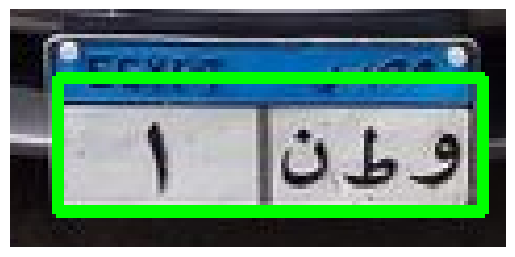

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Recognized Text: ['']


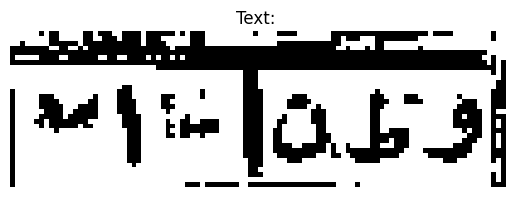

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr

def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to binarize the image
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    return threshold

def recognize_characters(char_images):
    reader = easyocr.Reader(['en'])  # Initialize EasyOCR with English language support
    recognized_text = []

    for char_image in char_images:
        # Use EasyOCR to recognize the character
        result = reader.readtext(char_image)

        # Extract the recognized text from the result
        if result:
            char_text = result[0][-1]
            recognized_text.append(char_text)
        else:
            recognized_text.append("")

    return recognized_text

def segment_characters(image_path):
    # Preprocess the image
    preprocessed_img = preprocess_image(image_path)

    # Find contours in the image
    contours, _ = cv2.findContours(preprocessed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image to draw contours
    img_with_contours = cv2.imread(image_path)

    # List to store individual character images
    character_images = []

    for contour in contours:
        # Get the perimeter of the contour
        perimeter = cv2.arcLength(contour, True)

        # Approximate the contour with a polygon
        epsilon = 0.06 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Filter out contours with small area
        if cv2.contourArea(approx) > 50:
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(approx)

            # Extract the character region from the original image
            character = preprocessed_img[y:y+h, x:x+w]

            # Append the character image to the list
            character_images.append(character)

            # Draw a rectangle around the character on the original image
            cv2.rectangle(img_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the image with contours
    plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Recognize characters using EasyOCR
    recognized_text = recognize_characters(character_images)
    print("Recognized Text:", recognized_text)

    # Display individual character images
    for i, char_image in enumerate(character_images):
        plt.subplot(1, len(character_images), i + 1)
        plt.imshow(char_image, cmap='gray')
        plt.title(f"Text: {recognized_text[i]}")
        plt.axis('off')

    plt.show()

# Example usage
image_path = r"D:\car_plate_detection\EALPR_master\Plates_dataset\0003_license_plate_1.png"
segment_characters(image_path)


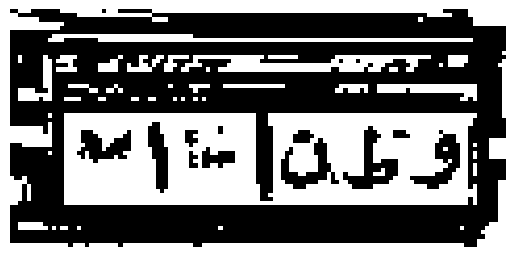

Number of characters: 3


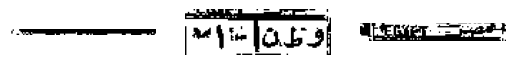

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Constants
CONTOUR_AREA_THRESHOLD = 50
EPSILON_FACTOR = 0.04

def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to binarize the image
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    return threshold

def find_and_filter_contours(image):
    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > CONTOUR_AREA_THRESHOLD]

    return filtered_contours

def draw_and_extract_characters(image, contours):
    # Create a copy of the original image to draw contours
    img_with_contours = image.copy()

    # List to store individual character images
    character_images = []

    for contour in contours:
        # Get the perimeter of the contour
        perimeter = cv2.arcLength(contour, True)

        # Approximate the contour with a polygon
        epsilon = EPSILON_FACTOR * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(approx)

        # Extract the character region from the original image
        character = image[y:y+h, x:x+w]

        # Append the character image to the list
        character_images.append(character)

        # Draw a rectangle around the character on the original image
        cv2.rectangle(img_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return img_with_contours, character_images

def display_images_with_contours(img_with_contours, character_images):
    # Display the image with contours
    plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    print(f"Number of characters: {len(character_images)}")

    # Display individual character images
    for i, char_image in enumerate(character_images):
        plt.subplot(1, len(character_images), i + 1)
        plt.imshow(char_image, cmap='gray')
        plt.axis('off')

    plt.show()

def segment_characters(image_path):
    # Preprocess the image
    preprocessed_img = preprocess_image(image_path)

    # Find and filter contours
    contours = find_and_filter_contours(preprocessed_img)

    # Draw contours and extract characters
    img_with_contours, character_images = draw_and_extract_characters(preprocessed_img, contours)

    # Display images with contours
    display_images_with_contours(img_with_contours, character_images)

# Example usage
image_path = r"D:\car_plate_detection\EALPR_master\Plates_dataset\0003_license_plate_1.png"
segment_characters(image_path)


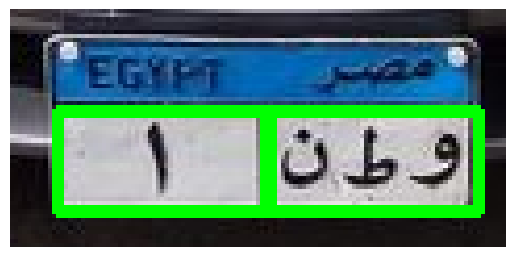

2


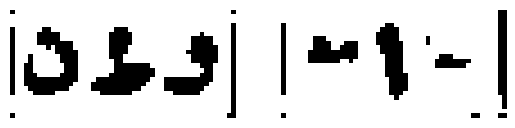

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive thresholding to binarize the blurred image
    threshold = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    return threshold

def segment_characters(image_path):
    # Preprocess the image
    preprocessed_img = preprocess_image(image_path)

    # Find contours in the image
    contours, _ = cv2.findContours(preprocessed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image to draw contours
    img_with_contours = cv2.imread(image_path)

    # List to store individual character images
    character_images = []

    for contour in contours:
        # Get the perimeter of the contour
        perimeter = cv2.arcLength(contour, True)

        # Approximate the contour with a polygon
        epsilon = 0.06 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Filter out contours with small area
        if cv2.contourArea(approx) > 50:
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(approx)

            # Extract the character region from the original image
            character = preprocessed_img[y:y+h, x:x+w]

            # Append the character image to the list
            character_images.append(character)

            # Draw a rectangle around the character on the original image
            cv2.rectangle(img_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the image with contours
    plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(len(character_images))

    # Display individual character images
    for i, char_image in enumerate(character_images):
        plt.subplot(1, len(character_images), i + 1)
        plt.imshow(char_image, cmap='gray')
        plt.axis('off')

    plt.show()

# Example usage
image_path = r"D:\car_plate_detection\EALPR_master\Plates_dataset\0003_license_plate_1.png"
segment_characters(image_path)
